In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import sympy # equation solver
from scipy.optimize import optimize # minimizing
from scipy import stats # for 2d-histograms
import h5py # lese matlab data
# h5py-3.11.0
%matplotlib inline

# Constants, from Jenkins
rho_i=916
L_i=334000
rho_ic_i_k_i=2.1
rho_w=1030
c_w=3974
c_i=2108 # from internet, not in Jenkins tables

gamma_1=-0.0573
gamma_2=0.0832
gamma_3=-7.53*10**-4

# Elins' values
# CdTt=0.0011 # Thermal Stanton
# CdTs=3.1*10**-5 # Diffusion Stanton number
# CdTts=5.9*10**-4 # Stanton number - not used?

#CdTt=0.02*0.0011 # Thermal Stanton
#CdTs=0.15*3.1*10**-5 # Diffusion Stanton number

# best fit so far
# CdTt=0.15*0.0011 # Thermal Stanton
# CdTs=0.2*3.1*10**-5 # Diffusion Stanton number
# r2 = 0.65 for Pb O 400

CdTt=0.15*0.0011 # Thermal Stanton
CdTs=0.3*3.1*10**-5 # Diffusion Stanton number

CdTts=5.9*10**-4 # Stanton number - not used?
Cd=0.0097 # not used
Tt=0.011 # not used
Ts=3.1*10**-4 # not used
Tts=0.006 #  not used

# Fixed values
T_i=-20
S_w=34.4
Pb=360


# Constants, Elin
A=rho_i*L_i
B=rho_i*c_i*T_i #
C=rho_i*c_i  # 
D=rho_w*c_w*CdTt
E=rho_w*CdTs
F=gamma_2+gamma_3*Pb

# a is melt/second! multiply by numbers of seconds per year to get m/yr
N=365*24*3600



Try to implement minimization of RMS of observed melt and parameterized  melt based from 3-eqn solver following this recepie: https://datascience.stackexchange.com/questions/69092/how-to-minimize-mean-square-error-using-python

In [2]:
# read obs data
f = h5py.File('M2_series.mat','r')
print(f.keys())

num = np.array(f.get('num'))
dh = np.array(f.get('dh'))
vsr = np.array(f.get('vsr'))
vsr_lin = np.array(f.get('vsr_lin'))
t2 = np.array(f.get('t2'))
# spd2 = np.array(f.get('spd2')) # speed from filtered velocities
spd2 = np.array(f.get('spdf2')) # filtered speed

# tr2 = np.array(f.get('t2'))
spdf2 = np.array(f.get('spdf2'))

mm = -(dh-np.mean(vsr,axis=0))
# mm = -(dh-np.mean(vsr,axis=0))-0.45 # offset of staek strain
# mm = -(dh-vsr_lin)-0.45 # offset of staek strain
t = t2.T
spd = spd2.T
spd_ = spdf2.T

# find non-neagtive values
ii = np.isfinite(spd * t * mm) # & (spd>0.05)

UU = spd[ii] # + 0.07 fits magntude, but worsens r2
TT = t[ii] # + 0.15
mm_obs = mm[ii]

print('langley dh = ')
print(str(-(0.9+0.84)))

print('ApRES dh = ')
print(str(np.nanmean(dh)))

print('stake strain = ')
print(str(0.9))
print('ApRES strain = ')
print(str(np.mean(vsr,axis=0)))


<KeysViewHDF5 ['dh', 'dh_lin', 'melt_lin', 'num', 'spd2', 'spd_lin', 'spdf2', 'spdr2', 't2', 't_lin', 'tr2', 'vsr', 'vsr_lin']>
langley dh = 
-1.74
ApRES dh = 
-1.4937287418223097
stake strain = 
0.9
ApRES strain = 
[-0.44673078]


In [3]:

# Fixed values
T_i=0
S_w=34.4
Pb=340

def melt_para(ftt,fts,toff,uoff):
    aa=[]
    # CdTt=0.15*0.0011 # Thermal Stanton
    # CdTs=0.2*3.1*10**-5 # Diffusion Stanton number
    CdTt=ftt*0.0011 # Thermal Stanton
    # CdTs=fts*3.1*10**-5 # Diffusion Stanton number
    CdTs=CdTt/30

    # Constants, Elin
    A=rho_i*L_i
    B=rho_i*c_i*T_i #
    C=rho_i*c_i  # 
    D=rho_w*c_w*CdTt
    E=rho_w*CdTs
    F=gamma_2+gamma_3*Pb

    T = TT + toff
    U = UU + uoff
    aa=rho_i*(B-A-C*F)
    bb=E*(B-A)-C*gamma_1*S_w*E-C*F*E-D*U*F*rho_i+D*U*T*rho_i
    cc=D*U*T*E-D*U*F*E-D*U*gamma_1*S_w*E
    aa=N*(-bb-np.sqrt(bb**2-4*aa*cc))/(2*aa) # meltrate [m/yr]
    # add convective part
    # aa[U<0.02] = aa[U<0.02] +1.93*np.abs(T[U<0.02]+2.15)**(4/3)
    # aa[U<0.02] = aa[U<0.02] +2.5*np.abs(T[U<0.02]+2.15)**(4/3)
    # aa = aa +5.5*np.abs(T+2.15)**(4/3)
    # aa = aa +2*np.abs(T+2.15)**(4/3)
    aa = aa +fts*np.abs(T+2.15)**(4/3)
   
    return aa


# from sklearn.metrics import r2_score

def r2_score_man(y_obs, y_pred):
    """
    Calculate the coefficient of determination (R^2) between the observed data and the predicted data.

    Parameters:
    y_obs (numpy array): The observed data.
    y_pred (numpy array): The predicted data.

    Returns:
    float: The R^2 value.
    """
    # Calculate the residuals (differences between observed and predicted data)
    resid = y_pred - y_obs
    
    # Calculate the sum of squares of residuals
    SSresid = np.sum(resid ** 2)
    
    # Calculate the total sum of squares (variance of the observed data times the number of observations minus one)
    # Note: np.var with ddof=1 calculates the sample variance
    SStotal = (len(y_obs) - 1) * np.var(y_obs, ddof=1)
    
    # Calculate the R^2 value
    r2_val = 1 - SSresid / SStotal
    
    return r2_val

# Example usage
# ys = np.array([...])  # Observed data
# y1s = np.array([...]) # Predicted data
# r_squared = calculate_r_squared(ys, y1s)
# print(r_squared)

# mm_par = melt_para(ftt,fts,toff,soff)
# mm_par = melt_para(0.15,0.2,0,0)

# first extension with so far best fit
#ftt = np.arange(0.01, 0.1, 0.005) # np.array([0.01, 0.05, 0.15, 0.2, 0.5, 1, 1.5])
#fts = np.array([0.005, 0.007, 0.01, 0.013, 0.015, 0.4, 0.5, 0.6]) # np.arange(0.01, 1.2, 0.01) # np.array([0.01, 0.05, 0.15, 0.2, 0.5, 1, 1.5])
#toffs = np.arange(-0.15, 0.15, 0.01) 
#uoffs = np.arange(-0.02, 0.08, 0.01) # np.arange(-0.1, 0.1, 0.01) 



ftt = np.arange(0.01, 0.1, 0.005) # np.array([0.01, 0.05, 0.15, 0.2, 0.5, 1, 1.5])
fts = np.array([0.005, 0.007, 0.01, 0.013, 0.015, 0.4, 0.5, 0.6, 1.5]) # np.arange(0.01, 1.2, 0.01) # np.array([0.01, 0.05, 0.15, 0.2, 0.5, 1, 1.5])
toffs = np.arange(-0.15, 0.15, 0.01) 
uoffs = np.arange(-0.02, 0.08, 0.01) # np.arange(-0.1, 0.1, 0.01) 

# large fts values
#ftt = np.arange(0.01, 0.2, 0.005) # np.array([0.01, 0.05, 0.15, 0.2, 0.5, 1, 1.5])
#fts = np.array([0.01, 0.1, 1, 1.5, 10, 10^5, 10**6, 5*10**7, 10**8, 5*10**8, 10**10, 10**15]) # np.arange(0.01, 1.2, 0.01) # np.array([0.01, 0.05, 0.15, 0.2, 0.5, 1, 1.5])
#toffs = np.arange(-0.16, 0.16, 0.02) 
#offs = np.arange(-0.02, 0.08, 0.01) # np.arange(-0.1, 0.1, 0.01) 

# original small set with good fit for offset, explore large fts gives best fit with square of filtered velocities
ftt = np.array([0.09, 0.15, 1, 1.5, 15, 150]) # np.arange(0.05, 0.15, 0.01)
fts = np.array([0.2, 0.25, 0.3, 0.35, 1, 10**9, 5*10**9, 10**10, 5*10**10, 10**11])
toffs = np.arange(-0.05, 0.15, 0.01) 
uoffs = np.arange(-0.05, 0.1, 0.01) 


# explor optiosn to add convective mixing
#ftt = np.array([1, 2, 10])
ftt = np.arange(0.01, 0.15, 0.02) # np.array([0.01, 0.05, 0.09, 0.15, 0.2, 0.5, 0.7, 1, 1.5]) # np.arange(0.05, 0.15, 0.01)
# ftt = np.arange(0.1, 1.5, 0.1)
#fts = np.array([0.2, 0.25, 0.3, 0.35, 1, 10**9, 5*10**9, 10**10, 5*10**10, 10**11])
#fts = np.array([0.1, 0.5, 1, 10])
#fts = np.array([1])
#fts = np.arange(20, 40, 2) # np.array([25, 30, 35, 50])
fts = np.array([0, 2, 4])
toffs = np.arange(-0.05, 0.15, 0.01) 
uoffs = np.arange(-0.05, 0.1, 0.01) 


# original small set with good fit for offset
#ftt = np.array([0.01, 0.05, 0.15, 0.2, 0.5, 1, 1.5])
#fts = np.array([0.01, 0.05, 0.15, 0.2, 0.5, 1, 1.5])
#toffs = np.arange(-0.15, 0.15, 0.01) 
#uoffs = np.arange(-0.1, 0.1, 0.01) 

print('initialize arrays')

mm_pars = np.zeros((len(ftt), len(fts), len(toffs), len(uoffs), len(ii)))*np.nan
mm_r2s_off = np.zeros((len(ftt), len(fts), len(toffs), len(uoffs)))
mm_r2s_abs = np.zeros((len(ftt), len(fts), len(toffs), len(uoffs)))

print('start loop')

for i in range(ftt.size):
    #print(str(i))
    for j in range(fts.size):
        for k in range(toffs.size):
            for l in range(uoffs.size):
                dum = np.array(melt_para(ftt[i],fts[j],toffs[k],uoffs[l]))
                
                mm_pars[i, j, k, l, np.squeeze(ii)] = dum
                mm_r2s_off[i, j, k, l] = r2_score_man(mm_obs-np.mean(mm_obs), dum-np.mean(dum))
                mm_r2s_abs[i, j, k, l] = r2_score_man(mm_obs, dum)
    sys.stdout.write('.')
                #print(str(i))
                #print(str(j))
                #print(str(k))
                #print(str(l))    
    
print('done')


initialize arrays
start loop
.......done


In [31]:
from scipy.optimize import minimize # minimizing

print('Find optimal fit of melt rate paremeterization')
print('DEFINE f1: variable GammaT, offset in T and U, no melt offset, no convective melt')

# compute quantiles for comparing the distributions
qts = np.arange(0.001, 0.999, 0.001) 
qmmq = np.quantile(mm[ii],qts)

def f(params):
    dum = np.array(melt_para(params[0],params[1],params[2],params[3]))
    # dum = np.array(melt_para(params[0],0,params[2],params[3]))
    
    # return 1-r2_score_man(mm[ii], dum) # minimize for absolute error
    
    q_ = np.quantile(dum,qts)
    return 1-r2_score_man(qmmq, q_) # minimize for distribution shape
    
print('DEFINE f1: variable GammaT, melt offset, include convective melt, offset in T and U')
print('')
def f2(params):
    #dum = np.array(melt_para(params[0],2,params[2],params[3]))

    # no temp offset, no u offset
    # dum = np.array(melt_para(params[0],params[1],0,0))

    # no temp offset
    dum = np.array(melt_para(params[0],params[1],0,params[3]))

    # all free (gives positive melt offset)
    # dum = np.array(melt_para(params[0],params[1],params[2],params[3]))
    
    # return 1-r2_score_man(mm[ii] + params[4], dum) # minimize for absolute error
    
    qmo = np.quantile(mm[ii] + params[4],qts)
    q_ = np.quantile(dum,qts)
    return 1-r2_score_man(qmo, q_) # minimize for distribution shape


print('best initial guess:')
# opti_arr = [ftt[im_abs[0]], fts[im_abs[1]], toffs[im_abs[2]], uoffs[im_abs[3]], [0.5]]
# opti_arr = [ftt[im_abs[0]], fts[im_abs[1]], [0], [0]]
# initial_guess = np.squeeze(np.array(opti_arr).T)
initial_guess = [0.1, 2, 0.1, 0.05, 0.5]
print(initial_guess)
print('')

print('1-r2 f(initial_guess)')
r2 = f(initial_guess)
print(r2)
print('')

print('1-r2 f2(initial_guess)')
r2 = f(initial_guess)
print(r2)
print('')

print('########## MINIMIZE f1:')
# result = minimize(f, initial_guess, method='Powell') # encounters nan
# result = minimize(f, initial_guess, method='CG', options={'maxiter':2000}) # solves with precisison loss for absolute offset
result = minimize(f, initial_guess, method='BFGS') # solves well for absolute offset; precision loss for distribuion
print(result)
print('')

print('########## MINIMIZE f2:')
result2 = minimize(f2, initial_guess, method='CG', options={'maxiter':2000}) # solves well for absolute offset; precision loss for distribution
# result2 = minimize(f2, initial_guess, method='BFGS') 
print(result2)
print('')

# fill back into gappy time series
mm_opti = np.zeros(len(ii))*np.nan
mm_opti2 = np.zeros(len(ii))*np.nan
mm_opti_conv = np.zeros(len(ii))*np.nan
mm_opti2_conv = np.zeros(len(ii))*np.nan

#mm_opti[np.squeeze(ii)]= melt_para(result.x[0],  0 , result.x[2], result.x[3]) # solution f1
mm_opti[np.squeeze(ii)]= melt_para(result.x[0],  result.x[1] , result.x[2], result.x[3]) # solution f1
mm_opti_conv[np.squeeze(ii)]= melt_para(result.x[0],  result.x[1] , result.x[2], result.x[3]) -  melt_para(result.x[0],  0 , result.x[2], result.x[3]) # solution f1


# no temp offset no u offset
# mm_opti2[np.squeeze(ii)] = melt_para(result2.x[0], result2.x[1], 0, 0) # solution f2
# mm_opti2_conv[np.squeeze(ii)] = melt_para(result2.x[0], result2.x[1], 0, result2.x[3]) - melt_para(result2.x[0], 0, 0, 0) # Mandiak's convective contribution

# no temp offset 
mm_opti2[np.squeeze(ii)] = melt_para(result2.x[0], result2.x[1], 0, result2.x[3]) # solution f2
mm_opti2_conv[np.squeeze(ii)] = melt_para(result2.x[0], result2.x[1], 0, result2.x[3]) - melt_para(result2.x[0], 0, 0, result2.x[3]) # Mandiak's convective contribution

print('r2 f(optimized)')
print(str(r2_score_man(mm[ii], mm_opti[np.squeeze(ii)])))
print('r2 f2(optimized)')
print(str(r2_score_man(mm[ii]+result2.x[4], mm_opti2[np.squeeze(ii)])))
print('')


Find optimal fit of melt rate paremeterization
DEFINE f1: variable GammaT, offset in T and U, no melt offset, no convective melt
DEFINE f1: variable GammaT, melt offset, include convective melt, offset in T and U

best initial guess:
[0.1, 2, 0.1, 0.05, 0.5]

1-r2 f(initial_guess)
0.6331313655187083

1-r2 f2(initial_guess)
0.6331313655187083

########## MINIMIZE f1:
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.0022037450186092045
        x: [ 1.015e-01  1.475e+00  2.111e-01  3.118e-04  5.000e-01]
      nit: 40
      jac: [ 3.159e-04 -1.629e-05  1.828e-04 -1.059e-05  0.000e+00]
 hess_inv: [[ 2.139e-03  6.569e-03 ...  1.800e-04  0.000e+00]
            [ 6.569e-03  2.741e-02 ...  6.392e-04  0.000e+00]
            ...
            [ 1.800e-04  6.392e-04 ...  2.717e-05  0.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
     nfev: 712
     njev: 117

########## MINIMIZE f2:
 message: Desired error n

Optimize linear regression: melt = (T**a * u**b * slope + intercept ) for a and b
best initial guess:
[1, 1]

########## MINIMIZE regression:
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.015383263481805853
       x: [ 6.488e-01  7.786e-01]
     nit: 4
   direc: [[ 1.000e+00  0.000e+00]
           [-2.250e-02 -2.415e-02]]
    nfev: 143

optimized regression, non-linear
LinregressResult(slope=30.682887837757068, intercept=0.34756404393880325, rvalue=0.8781281364244078, pvalue=0.0, stderr=0.14355648977670665, intercept_stderr=0.0034629521438247672)

regression, linear
LinregressResult(slope=84.10578522045053, intercept=0.5464322324346802, rvalue=0.8795594590790947, pvalue=0.0, stderr=0.39070161342824655, intercept_stderr=0.002631540419820938)

Compute time series and max and min versions based on regression error
r2 regression(optimized)
0.7711090239802032
r2 regression(linear)
0.7736248420555096


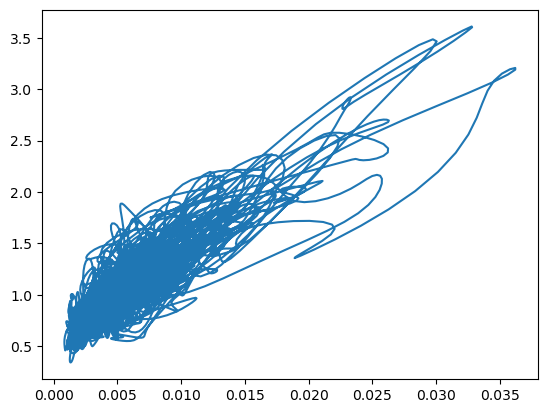

In [40]:
print('Optimize linear regression: melt = (T**a * u**b * slope + intercept ) for a and b')

def f_reg(pots):
    x = (TT - (gamma_1*S_w + gamma_2 + gamma_3*Pb))**pots[0] * (UU**pots[1]) 
    #x = (TT - (gamma_1*S_w + gamma_2 + gamma_3*Pb))**1 * (UU**1) # linear
    reg = stats.linregress(x, mm[ii], alternative='greater')
    dum = reg.slope * x + reg.intercept
    #return 1-r2_score_man(mm[ii], dum)
    
    q_ = np.quantile(dum,qts)
    return 1-r2_score_man(qmmq, q_)

print('best initial guess:')
initial_guess = [1, 1]
print(initial_guess)
print('')

print('########## MINIMIZE regression:')
result_reg = minimize(f_reg, initial_guess, method='Powell')
print(result_reg)
print('')

print('optimized regression, non-linear')
x = (TT-(gamma_1*S_w + gamma_2 + gamma_3*Pb))**result_reg.x[0] * (UU**result_reg.x[1])
reg = stats.linregress(x, mm[ii], alternative='greater')
print(reg)
print('')

print('regression, linear')
x_lin = (TT-(gamma_1*S_w + gamma_2 + gamma_3*Pb)) * (UU)
reg_lin = stats.linregress(x_lin, mm[ii], alternative='greater')
print(reg_lin)
print('')

fig,ax=plt.subplots()
ax.plot(x_lin,mm[ii])

print('Compute time series and max and min versions based on regression error')
dum = reg.slope * x + reg.intercept
dum_u = (reg.slope + reg.stderr) * x + reg.intercept + reg.intercept_stderr
dum_l = (reg.slope - reg.stderr) * x + reg.intercept - reg.intercept_stderr
dum_lin = reg_lin.slope * x_lin + reg_lin.intercept


# fill back into gappy time series
mm_reg = np.zeros(len(ii))*np.nan
mm_reg_u = np.zeros(len(ii))*np.nan
mm_reg_l = np.zeros(len(ii))*np.nan
mm_reg_lin = np.zeros(len(ii))*np.nan

mm_reg[np.squeeze(ii)] = dum
mm_reg_u[np.squeeze(ii)] = dum_u
mm_reg_l[np.squeeze(ii)] = dum_l
mm_reg_lin[np.squeeze(ii)] = dum_lin

print('r2 regression(optimized)')
print(str(r2_score_man(mm[ii], mm_reg[np.squeeze(ii)])))
print('r2 regression(linear)')
print(str(r2_score_man(mm[ii], mm_reg_lin[np.squeeze(ii)])))

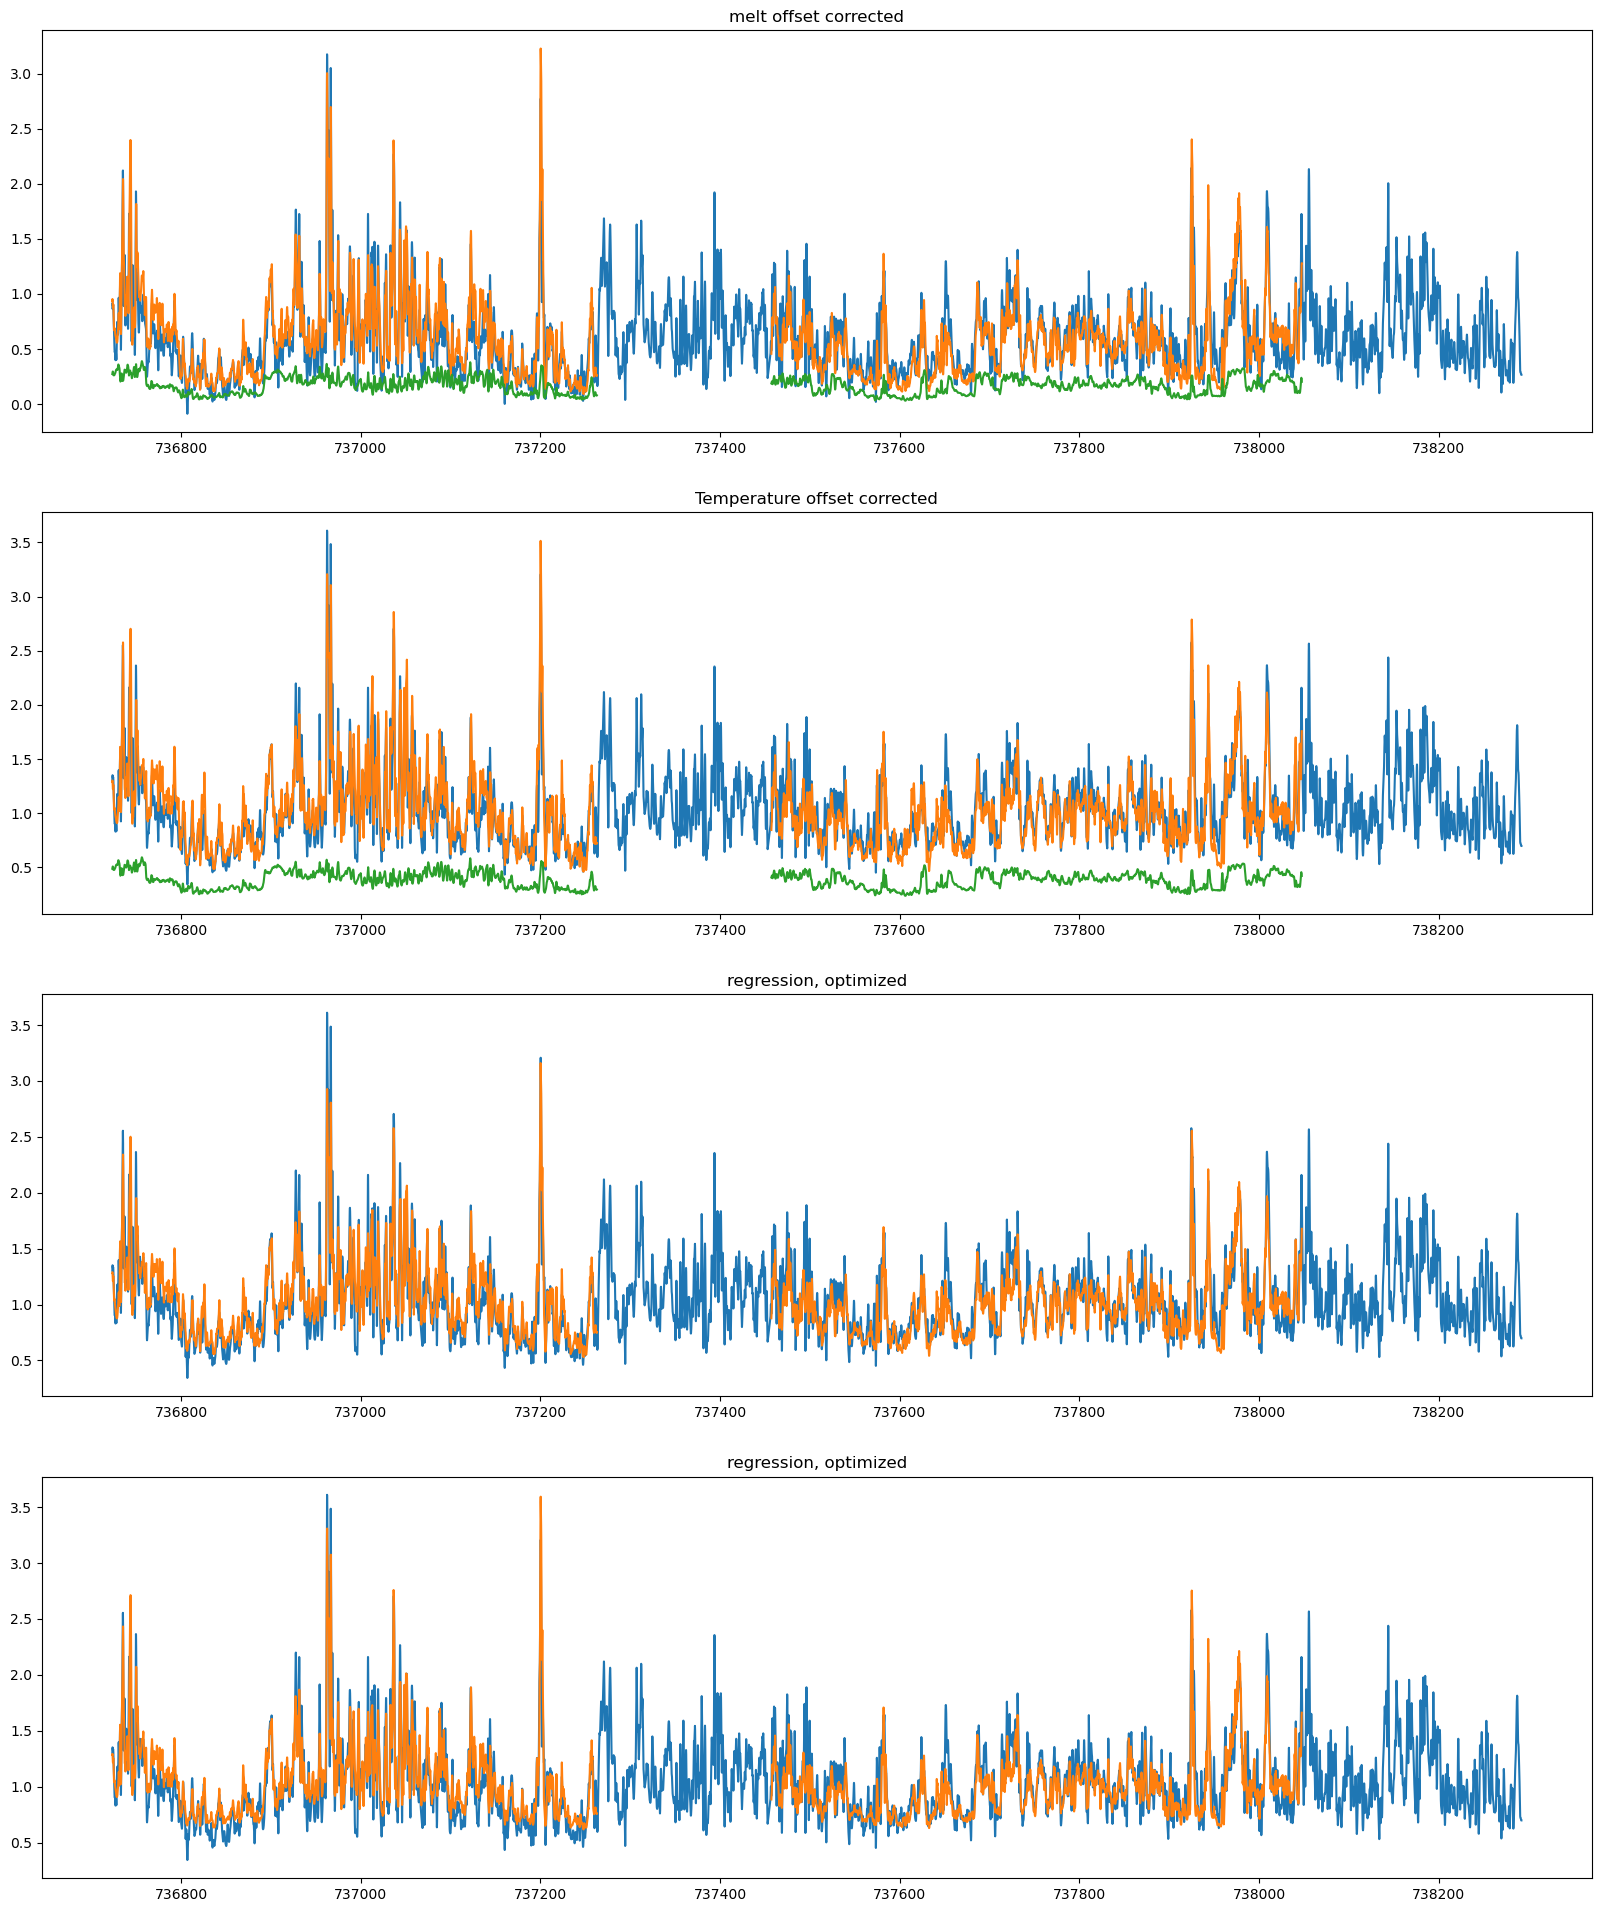

In [112]:
# plotting
plt.rcParams.update({'font.size': 10})

fig,ax=plt.subplots(4)
fig.set_figwidth(20)
fig.set_figheight(24)

ax[0].plot(num, mm + result2.x[4])
ax[0].plot(np.squeeze(num), np.squeeze(mm_opti2))
ax[0].plot(np.squeeze(num), np.squeeze(mm_opti2_conv))
ax[0].set_title('melt offset corrected')

ax[1].plot(num, mm)
ax[1].plot(np.squeeze(num), np.squeeze(mm_opti))
ax[1].plot(np.squeeze(num), np.squeeze(mm_opti_conv))
ax[1].set_title('Temperature offset corrected')

ax[2].plot(num, mm)
ax[2].plot(np.squeeze(num), np.squeeze(mm_reg))
#ax[2].plot(np.squeeze(num), np.squeeze(mm_reg_u))
#ax[2].plot(np.squeeze(num), np.squeeze(mm_reg_l))
ax[2].set_title('regression, optimized')

ax[3].plot(num, mm)
ax[3].plot(np.squeeze(num), np.squeeze(mm_reg_lin))
ax[3].set_title('regression, optimized')

plt.show()

C:\Users\hattermann\AppData\Local\Temp\ipykernel_22596\3111514689.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Spectral_r', 64)
C:\Users\hattermann\AppData\Local\Temp\ipykernel_22596\3111514689.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ins0.plot(ll,ll,'k',color="C{}".format(0))
C:\Users\hattermann\AppData\Local\Temp\ipykernel_22596\3111514689.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ins1.plot(ll,ll,'k',color="C{}".format(0))
C:\Users\hattermann\AppData\Local\Temp\ipykernel_22596\3111514689.py:66: UserWarning: colo

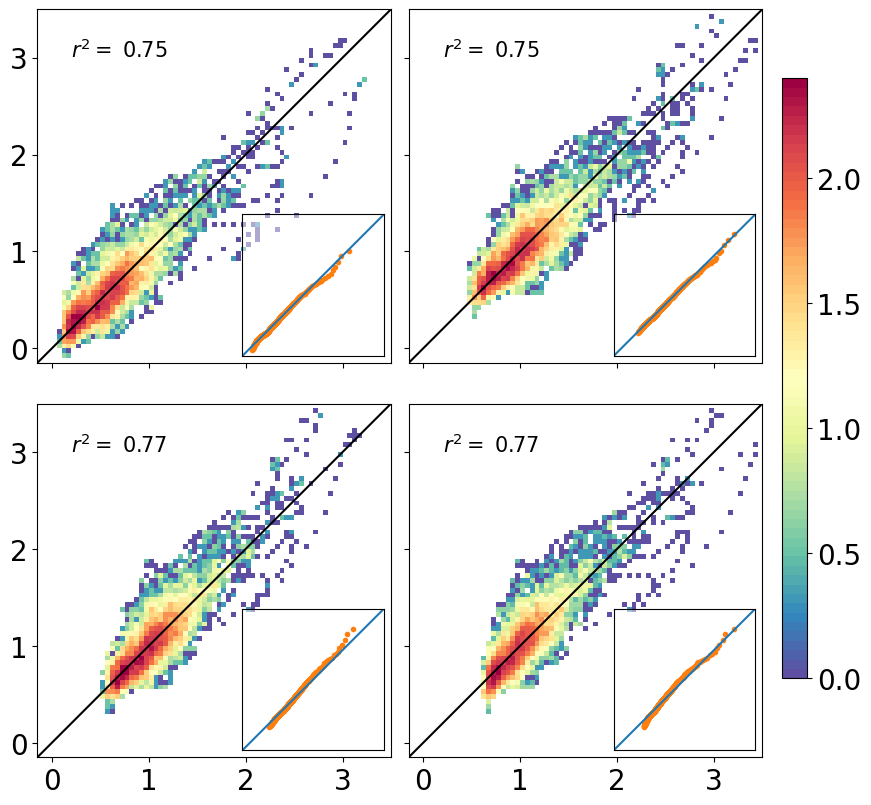

In [111]:
# 2d histograms of data distribution
cmap = plt.cm.get_cmap('Spectral_r', 64)
mbins  = np.arange(-0.1, 3.5, 0.05)
ll = [-0.15, 3.5]
al = 0.5

# qunatiles for quant-quant plot
qts = np.arange(0.001, 0.999, 0.001) 
qmmq = np.quantile(mm[ii],qts)
qmmq_off = np.quantile(mm[ii]+ result2.x[4],qts)
qmmq_opti = np.quantile(mm_opti[np.squeeze(ii)],qts)
qmmq_opti2 = np.quantile(mm_opti2[np.squeeze(ii)],qts)
qmmq_reg = np.quantile(mm_reg[np.squeeze(ii)],qts)
qmmq_reg_lin = np.quantile(mm_reg_lin[np.squeeze(ii)],qts)

# initailize figure
plt.rcParams.update({'font.size': 20})
fig,ax=plt.subplots(2,2)
fig.set_figwidth(10)
fig.set_figheight(10)
ins_loc = [0.58,0.02,0.4,0.4]
r2_loc = [0.2, 3]

##############################
ax[0,0].set(autoscale_on=False, adjustable="box", aspect='equal', xlim=ll, ylim=ll)
plt.sca(ax[0,0]) 
hist = stats.binned_statistic_2d(mm_opti2[np.squeeze(ii)], mm[ii] + result2.x[4], None, bins=[mbins, mbins], statistic='count')  # Returns a object
hist.statistic[hist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf
image = plt.pcolormesh(mbins, mbins, np.log10(hist.statistic.T), cmap=cmap, shading='flat') 
ax[0,0].plot(ll,ll,'k')
plt.text(r2_loc[0],  r2_loc[1], '$r^2 = $ ' + str(round(r2_score_man(mm[ii], mm_opti[np.squeeze(ii)]),2)) , fontsize = 15)

ins0 = ax[0,0].inset_axes(ins_loc, xlim=(ll[0], ll[1]), ylim=(ll[0], ll[1]), xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ins0.set_aspect('equal', adjustable="datalim")
ins0.plot(qmmq_opti2, qmmq_off,'.',color="C{}".format(1))
ins0.plot(ll,ll,'k',color="C{}".format(0))
ins0.patch.set_alpha(al)

############################
ax[0,1].set(autoscale_on=False, adjustable="box", aspect='equal', xlim=ll, ylim=ll)
plt.sca(ax[0,1]) 
hist = stats.binned_statistic_2d( mm_opti[np.squeeze(ii)], mm[ii], None, bins=[mbins, mbins], statistic='count')  # Returns a object
hist.statistic[hist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf
image = plt.pcolormesh(mbins, mbins, np.log10(hist.statistic.T), cmap=cmap, shading='flat') 
ax[0,1].plot(ll,ll,'k')
plt.text(r2_loc[0],  r2_loc[1], '$r^2 = $ ' + str(round(r2_score_man(mm[ii]+result2.x[4], mm_opti2[np.squeeze(ii)]),2)) , fontsize = 15)

ins1 = ax[0,1].inset_axes(ins_loc, xlim=(ll[0], ll[1]), ylim=(ll[0], ll[1]), xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ins1.set_aspect('equal', adjustable="datalim")
ins1.plot(qmmq_opti, qmmq,'.',color="C{}".format(1))
ins1.plot(ll,ll,'k',color="C{}".format(0))
ins1.patch.set_alpha(al)

###########################
ax[1,0].set(autoscale_on=False, adjustable="box", aspect='equal', xlim=ll, ylim=ll)
plt.sca(ax[1,0]) 
hist = stats.binned_statistic_2d( mm_reg[np.squeeze(ii)], mm[ii], None, bins=[mbins, mbins], statistic='count')  # Returns a object
hist.statistic[hist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf
image = plt.pcolormesh(mbins, mbins, np.log10(hist.statistic.T), cmap=cmap, shading='flat') 
ax[1,0].plot(ll,ll,'k')
plt.text(r2_loc[0],  r2_loc[1], '$r^2 = $ ' + str(round(r2_score_man(mm[ii], mm_reg[np.squeeze(ii)]),2)) , fontsize = 15)

ins2 = ax[1,0].inset_axes(ins_loc, xlim=(ll[0], ll[1]), ylim=(ll[0], ll[1]), xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ins2.set_aspect('equal', adjustable="datalim")
ins2.plot(qmmq_reg, qmmq,'.',color="C{}".format(1))
ins2.plot(ll,ll,'k',color="C{}".format(0))
ins2.patch.set_alpha(al)

##########################
ax[1,1].set(autoscale_on=False, adjustable="box", aspect='equal', xlim=ll, ylim=ll)
plt.sca(ax[1,1]) 
hist = stats.binned_statistic_2d( mm_reg_lin[np.squeeze(ii)], mm[ii], None, bins=[mbins, mbins], statistic='count')  # Returns a object
hist.statistic[hist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf
image = plt.pcolormesh(mbins, mbins, np.log10(hist.statistic.T), cmap=cmap, shading='flat') 
ax[1,1].plot(ll,ll,'k')
plt.text(r2_loc[0],  r2_loc[1], '$r^2 = $ ' + str(round(r2_score_man(mm[ii], mm_reg_lin[np.squeeze(ii)]),2)) , fontsize = 15)

ins3 = ax[1,1].inset_axes(ins_loc, xlim=(ll[0], ll[1]), ylim=(ll[0], ll[1]), xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ins3.set_aspect('equal', adjustable="datalim")
ins3.plot(qmmq_reg_lin, qmmq,'.',color="C{}".format(1))
ins3.plot(ll,ll,'k',color="C{}".format(0))
ins3.patch.set_alpha(al)

# # # # #
plt.subplots_adjust(wspace=0.05, hspace=0.05, right=0.85)
for ax_ in ax.flat:
    ax_.label_outer()

cbar_ax = fig.add_axes([0.87, 0.2, 0.025, 0.6])
fig.colorbar(image, cax=cbar_ax)
plt.savefig("../plot/melt_distribution.png")
plt.show()


In [9]:
np.shape(dum)

(13562,)

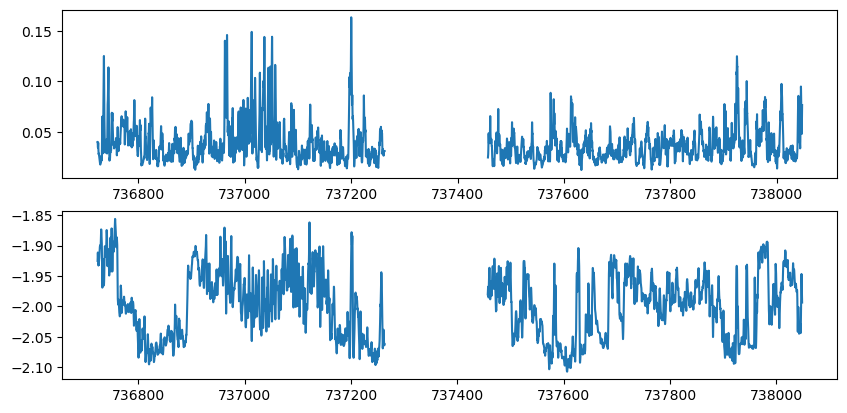

In [10]:
fig,ax=plt.subplots(2,1)
fig.set_figwidth(10)
ax[0].plot(num,spd)
ax[1].plot(num,t)

relation of melt rates to ocean properties.
At zero order, ice ablation increases with larger ambient ocean temperature and velocity as both factors enhance the fluxes across the ice-ocean boundary layer. From the conservation of heat and salt, a quadratic equation for the ablation rate can be found that generally yields a non-linear response to changes in ambient thermal driving T* and friction velocity u* = C_d^(1/2)*U_0, while a linearized expression is obtained under the assumption of small variations of the salinity in the boundary layer.

If shear-driven turbulence from ambient currents was the primary source of mixing across the IOBL, the ablation rate would decrease to zero when the free-stream velocity U_0 vanishes. However, recent studies showed boundary layer turbulence is caused  by natural convection (buoyancy- or shear-driven) beneath a sloping ice face that leads to finite ablation rates in absence of ambient currents (find better wording here). These DNS simulations suggest 

while other processes have been proposed to . However, recent studies have shown that intrinsic instabilities in the convectively driven turbulence in 


Assessment of melt parameterizations.

The observed melt rates can be parameterized. Several fits with different parameters. 3 eqn, 2 eqn, emprirical relationship.
Varying strain would indicate a decreasing trend in melt rate that is not supported by the ocean observations. While the 3eqn. parameterization captures a large fraction of the variability, explanations for the offsets in u and t and the linear strain are less obvious. The 3 eqn fit suggests an offset in the observed velocities of 4 cm/s, which leads to an underestimate of the melt rates for low velocities. This may be related to buoyant plumes that are rising along the sloping ice base and dominate the velocity structure at the ice-ocean interface under low background flow conditions. If the linear trend in the strain is related the ice dynamics of the basal channel, this may also affect the slope and hence the plume velocity, providing an explanation for a trend in melt rates that woudl not be observed as changes in ocean properties 30-40 m below the ice base where our mooring is situated. The offset in temperature/ thermal driving is still hard to explain (needing a temperature inversion below the ice base), casting doubt on the absolute magnitude of the observed (parameterized) melting (and strain).

Stanton numbers for:
3eqn with melt offset, 3eqn with t&u offset, 2eqn same way; derive Cd range, gammat/gammas ratio; compare fit & distributions; project melt rates back with unceratainty

C:\Users\hattermann\AppData\Local\Temp\ipykernel_22596\1479274952.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Spectral_r', 64)


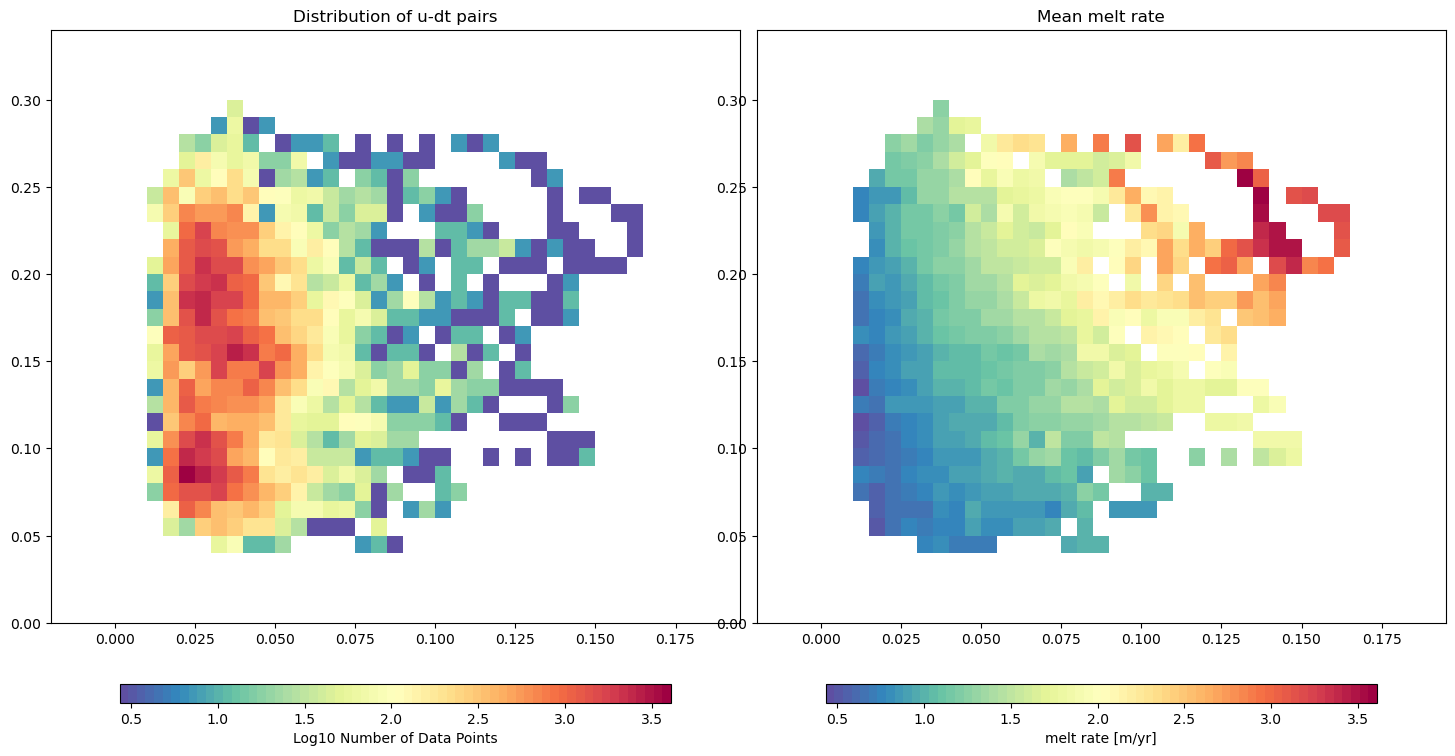

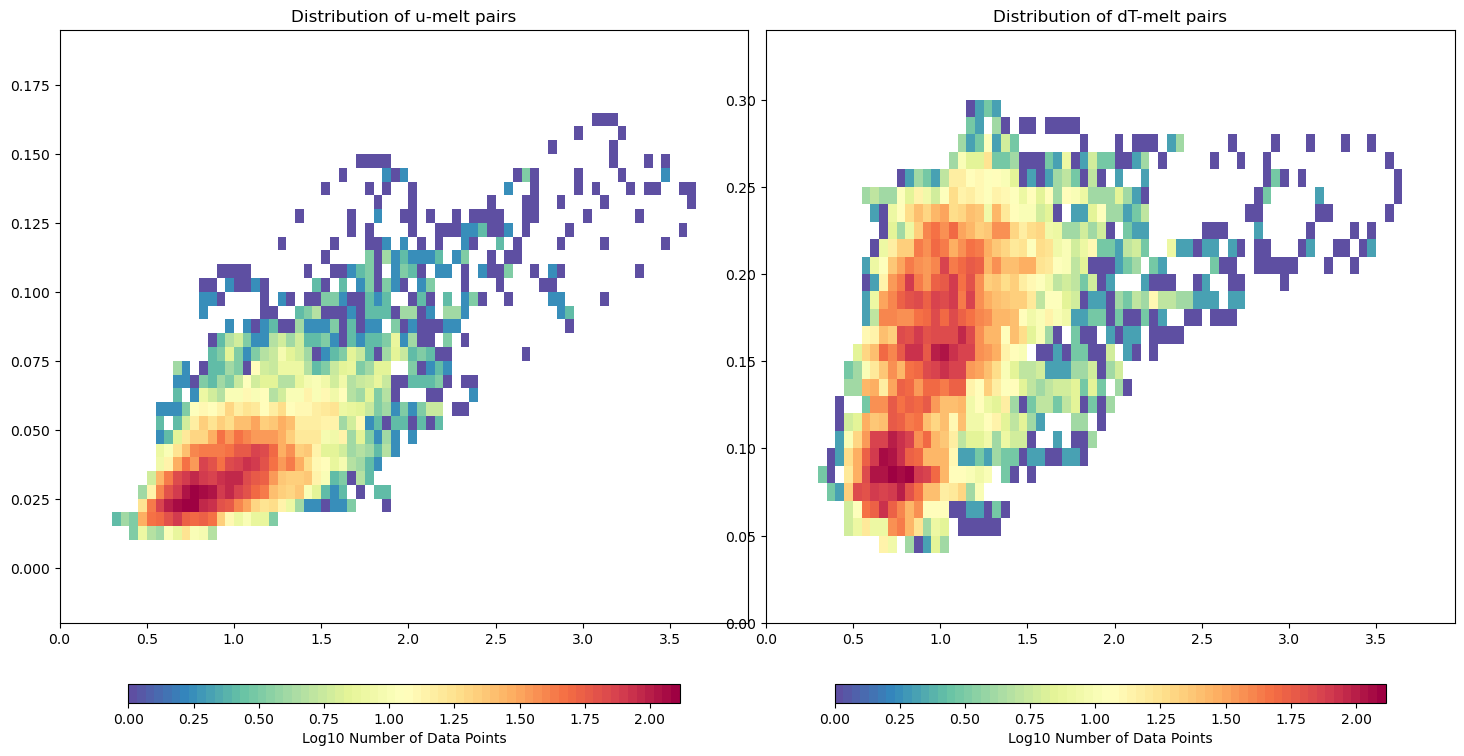

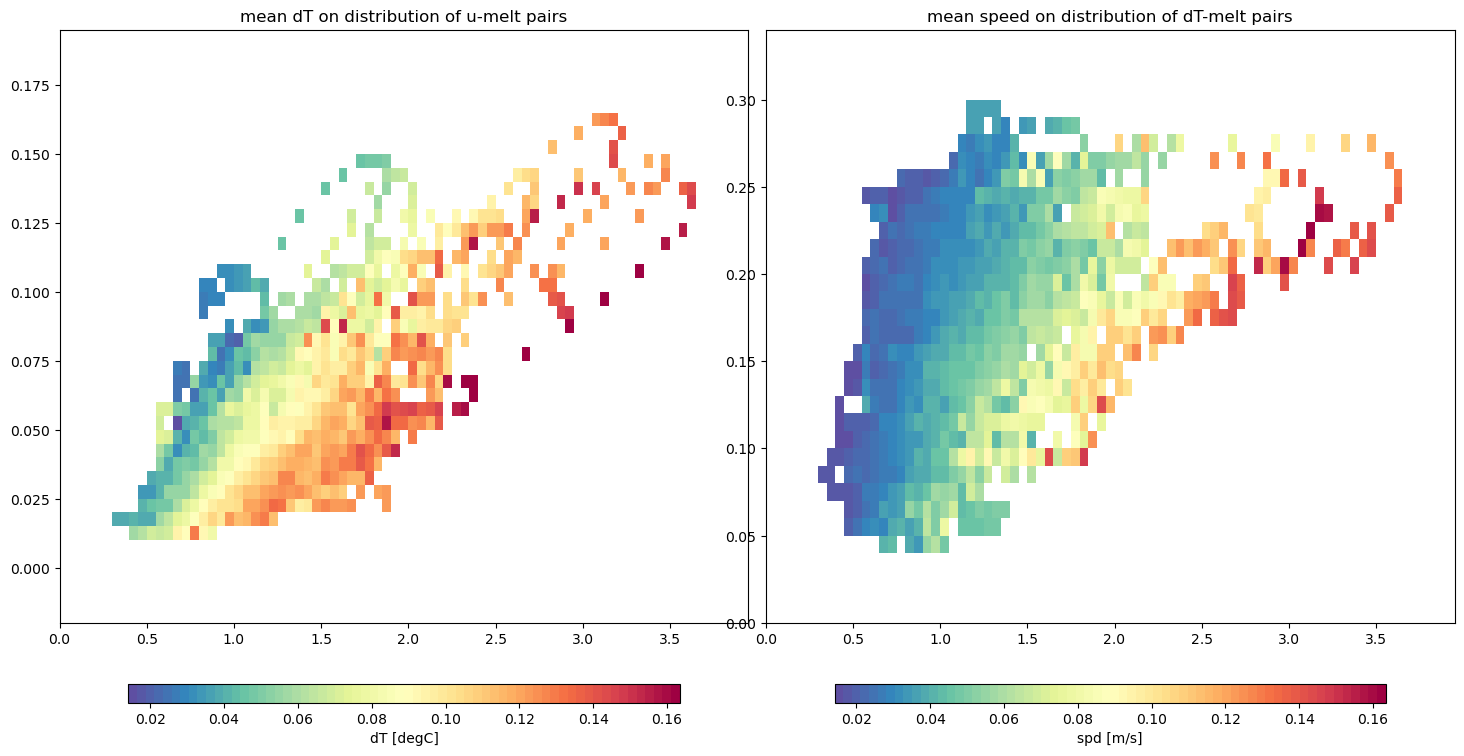

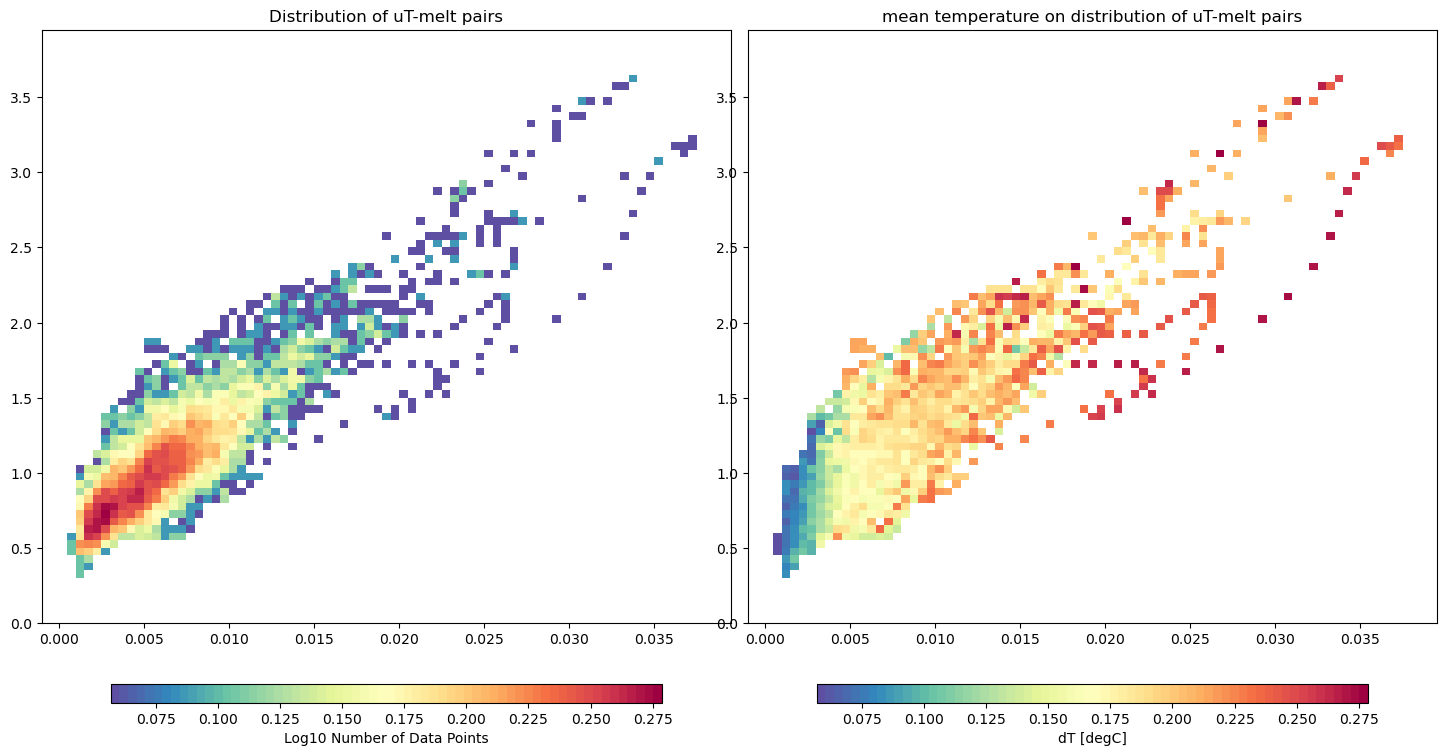

In [11]:
cmap = plt.cm.get_cmap('Spectral_r', 64)
dt = t+2.15 # thermal driving
bool = ~np.isnan(dt) & ~np.isnan(spd) & ~np.isnan(mm) # fint finite value tupels

dtbins = np.arange(0, 0.35, 0.01)
ubins = np.arange(-0.02, 0.2, 0.005)
mbins  = np.arange(0, 4, 0.05)
utbins  = np.arange(-0.001, 0.04, 0.0005)

hist = stats.binned_statistic_2d( spd[bool], dt[bool], None, bins=[ubins, dtbins], statistic='count')  # Returns a object
hist.statistic[hist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf

#In using stats.binned_statistic_2d, the input argument needs to be a 1-D array.  If you're using higher-
#dimensional data, such as model data, then you would want to flatten the input arrays with np.ravel(). 
#Similarly the input arguments should contain no NaNs.  If they do, you would want to remove then with
#bool = ~np.isnan(x) & ~np.isnan(y)
#hist = stats.binned_statistic_2d(x[bool], y[bool], None, bins=[xbins,ybins], statistic='mean').statistic  

mmean = stats.binned_statistic_2d( spd[bool], dt[bool], mm[bool], bins=[ubins, dtbins], statistic='mean')  # Returns a object

# melt rate space
muhist = stats.binned_statistic_2d( spd[bool], mm[bool], None, bins=[ubins, mbins], statistic='count')  # Returns a object
muhist.statistic[muhist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf
mumean = stats.binned_statistic_2d( spd[bool], mm[bool], dt[bool], bins=[ubins, mbins], statistic='mean')  # Returns a object


mthist = stats.binned_statistic_2d( dt[bool], mm[bool], None, bins=[dtbins, mbins], statistic='count')  # Returns a object
mthist.statistic[mthist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf
mtmean = stats.binned_statistic_2d( dt[bool], mm[bool], spd[bool], bins=[dtbins, mbins], statistic='mean')  # Returns a object

# u*t space

uthist = stats.binned_statistic_2d( dt[bool]*spd[bool], mm[bool], None, bins=[utbins, mbins], statistic='count')  # Returns a object
uthist.statistic[uthist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf
uttmean = stats.binned_statistic_2d( dt[bool]*spd[bool], mm[bool], dt[bool], bins=[utbins, mbins], statistic='mean')  # Returns a object

#################### plotting

fig, ax = plt.subplots(1, 2,figsize=np.array([18, 10]))

plt.sca(ax[0]) 
image = plt.pcolormesh(ubins, dtbins, np.log10(hist.statistic.T), cmap=cmap, shading='flat') 
plt.title('Distribution of u-dt pairs')

plt.sca(ax[1]) 
image = plt.pcolormesh(ubins, dtbins, mmean.statistic.T, cmap=cmap, shading='flat') 
plt.title('Mean melt rate')

plt.subplots_adjust(wspace=0.025)
fig.colorbar(image, ax=ax[0], orientation='horizontal', shrink=0.8, aspect=30, pad=0.08, label='Log10 Number of Data Points'); 
fig.colorbar(image, ax=ax[1], orientation='horizontal', shrink=0.8, aspect=30, pad=0.08, label='melt rate [m/yr]');

# metl distribution plots
fig, ax = plt.subplots(1, 2,figsize=np.array([18, 10]))

plt.sca(ax[0]) 
image = plt.pcolormesh(mbins, ubins, np.log10(muhist.statistic), cmap=cmap, shading='flat') 
plt.title('Distribution of u-melt pairs')

plt.sca(ax[1]) 
image = plt.pcolormesh(mbins, dtbins, np.log10(mthist.statistic), cmap=cmap, shading='flat') 
plt.title('Distribution of dT-melt pairs')

plt.subplots_adjust(wspace=0.025)
fig.colorbar(image, ax=ax[0], orientation='horizontal', shrink=0.8, aspect=30, pad=0.08, label='Log10 Number of Data Points'); 
fig.colorbar(image, ax=ax[1], orientation='horizontal', shrink=0.8, aspect=30, pad=0.08, label='Log10 Number of Data Points');

# melt mean plots
fig, ax = plt.subplots(1, 2,figsize=np.array([18, 10]))

plt.sca(ax[0]) 
image = plt.pcolormesh(mbins, ubins, mumean.statistic, cmap=cmap, shading='flat') 
plt.title('mean dT on distribution of u-melt pairs')

plt.sca(ax[1]) 
image = plt.pcolormesh(mbins, dtbins, mtmean.statistic, cmap=cmap, shading='flat') 
plt.title('mean speed on distribution of dT-melt pairs')

plt.subplots_adjust(wspace=0.025)
fig.colorbar(image, ax=ax[0], orientation='horizontal', shrink=0.8, aspect=30, pad=0.08, label='dT [degC]'); 
fig.colorbar(image, ax=ax[1], orientation='horizontal', shrink=0.8, aspect=30, pad=0.08, label='spd [m/s]');

# ut-melt plots
fig, ax = plt.subplots(1, 2,figsize=np.array([18, 10]))

plt.sca(ax[0]) 
image = plt.pcolormesh(utbins, mbins, np.log10(uthist.statistic.T), cmap=cmap, shading='flat') 
plt.title('Distribution of uT-melt pairs')

plt.sca(ax[1]) 
image = plt.pcolormesh(utbins, mbins, uttmean.statistic.T, cmap=cmap, shading='flat') 
plt.title('mean temperature on distribution of uT-melt pairs')

plt.subplots_adjust(wspace=0.025)
fig.colorbar(image, ax=ax[0], orientation='horizontal', shrink=0.8, aspect=30, pad=0.08, label='Log10 Number of Data Points'); 
fig.colorbar(image, ax=ax[1], orientation='horizontal', shrink=0.8, aspect=30, pad=0.08, label='dT [degC]');

In [12]:

fig, ax = map_setup(figsize,projection) 

ubar = stats.binned_statistic_2d(lat, lon, u, bins=[latbins, lonbins], statistic='mean')  
vbar = stats.binned_statistic_2d(lat, lon, v, bins=[latbins, lonbins], statistic='mean')  
meanflow = np.sqrt(ubar.statistic ** 2 + vbar.statistic ** 2)

image = plt.pcolormesh(lonbins, latbins, meanflow, cmap=cmap, shading='flat',transform=ccrs.PlateCarree()) 
plt.title('Speed of Mean Surface Currents')
plt.clim(0, 80) 

fig.colorbar(image, ax=ax, orientation='vertical', shrink=0.5, aspect=30, pad=0.05, label='Speed (cm/s)'); 

NameError: name 'map_setup' is not defined